## TP2 : Un perceptron pour la classification

- Coder l'apprentissage des poids d'un perceptron pour reconnaître les espèces de manchot d'après les valeurs numériques de la base suivante : https://raw.githubusercontent.com/allisonhorst/palmerpenguins/c19a904462482430170bfe2c718775ddb7dbb885/inst/extdata/penguins.csv
- Tracer l'évolution du taux d'erreur sur un ensemble d'apprentissage et un ensemble de test de votre choix et discuter les résultats


In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# lecture de la base de données
df = pd.read_csv("https://raw.githubusercontent.com/allisonhorst/palmerpenguins/c19a904462482430170bfe2c718775ddb7dbb885/inst/extdata/penguins.csv")
df = df.dropna() # pour supprimer les lignes avec des valeurs manquantes
print(df.head()) # pour afficher les premières lignes

# matrice des entrées (longueur du bec, largueur du bec, longueur des nageoires, poids du corps)
entrees = df[["bill_length_mm","bill_depth_mm","flipper_length_mm","body_mass_g"]].to_numpy()

# matrice des sorties (manchot Adélie, manchot Papou, manchot à jugulaire)
sp = ["Adelie","Gentoo","Chinstrap"]
sorties = np.zeros([len(df),len(sp)])
for s in range(len(sp)) :
   sorties[:,s] = df.species==sp[s]


  species     island  bill_length_mm  bill_depth_mm  flipper_length_mm  \
0  Adelie  Torgersen            39.1           18.7              181.0   
1  Adelie  Torgersen            39.5           17.4              186.0   
2  Adelie  Torgersen            40.3           18.0              195.0   
4  Adelie  Torgersen            36.7           19.3              193.0   
5  Adelie  Torgersen            39.3           20.6              190.0   

   body_mass_g     sex  year  
0       3750.0    male  2007  
1       3800.0  female  2007  
2       3250.0  female  2007  
4       3450.0  female  2007  
5       3650.0    male  2007  


Notre but est de pouvoir déterminer de quelle espèce vient le peinguin si l'on rentre ces données physionomiques.  
On va alors entrainer un réseau de neurones sur un jeu de données et on va avoir en entrée les attributs des peinguins et on connait la sortie.  
On va aussi separer le jeu de données en 2 : un d'entrainement et l'autre de test. Le but étant d'éviter le sur-apprentissage ou le sous-apprentissage.  
Cette séparation a pour but à apprendre au neurone de généraliser.
  
Pour notre réseau de neurone, on utilisera la loi de Widrow-Hoff qui va permettre d'ajuster les poids. On utilisera alors 3 neurones, chacun spécifiant une espèce.  
Ensuite, on va désigner le nombre d'itérations pour notre réseau.   
Puis pour chaque peinguin de notre jeu d'entrainement, on va calculer l'erreur entre la sortie attendue SA et la sortie réelle Sj, puis on met à jour les poids et biais en conséquence pour chaque espèce de peinguin (Adelie, Gentoo, Chinstrap). On va ensuite calculer la distance entre SA et Sj (quadratiquement) pour cette itération.  
On calcule l'erreur moyenne à la fin de l'itération et on l'ajoute à un tableau pour traquer.  
  
On fait la même pour le jeu de test puis on compare les deux tableaux d'erreurs moyennes.  


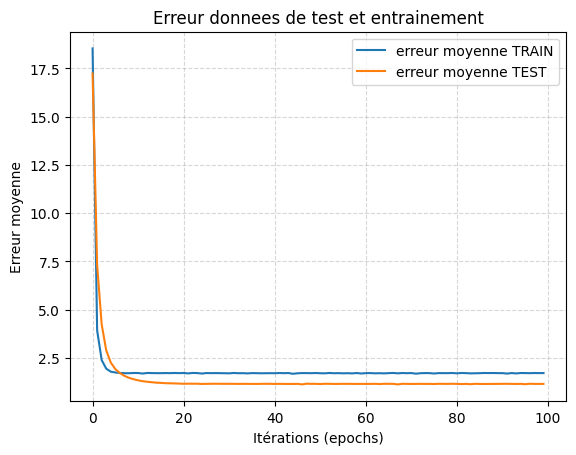

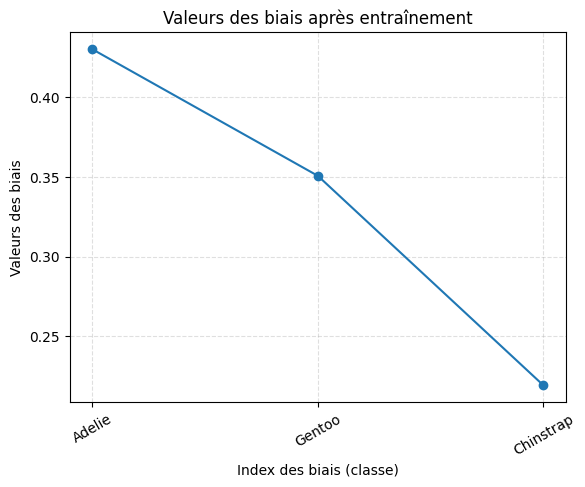

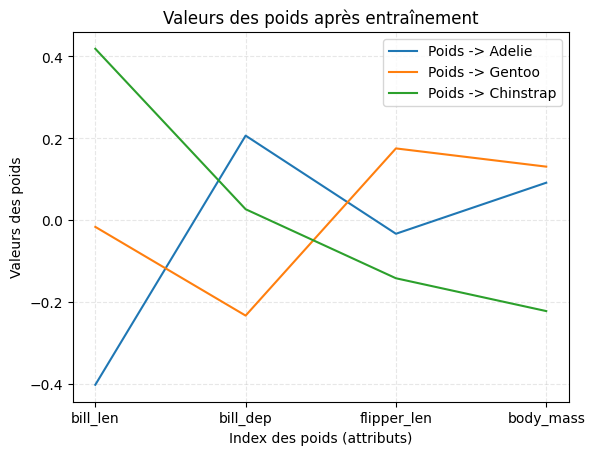

In [38]:
  # Normalisation (important : évite dominances d'échelle)
mu = entrees.mean(axis=0) # moyenne par colonne
sigma = entrees.std(axis=0) # écart-type par colonne
entrees = (entrees - mu) / sigma # standardisation donc on garde shape (N,d) et on modifie les valeurs pour centrer/réduire les données

# fonction pour diviser les données en un ensemble d'entrainement et un ensemble de test
def donnees_entrainement_test(entrees, sorties, proportion_test):
    nb_exemples = entrees.shape[0]
    nb_test = int(nb_exemples * proportion_test)
    indices = np.random.permutation(nb_exemples)
    test_idx, train_idx = indices[:nb_test], indices[nb_test:]
    return entrees[train_idx,:], sorties[train_idx,:], entrees[test_idx,:], sorties[test_idx,:]

'''
Définition

Epoch :
Dans le contexte de l'entraînement d'un modèle, l'"epoch" est un terme utilisé 
pour référer à une itération où le modèle voit tout le training set pour mettre à jour ses coefficients.
'''

def widrow_hoff(entrees, sorties, taux_apprentissage=0.01, epochs=10):
    ligne = entrees.shape[0]
    nb_attributs = entrees.shape[1]
    sortie_reelle = sorties.shape[1]

    # initialisation stable des poids / biais
    facteur_normalisation = 1 / np.sqrt(nb_attributs)
    matrice_poids = np.random.randn(nb_attributs, sortie_reelle) * facteur_normalisation
    vecteur_biais = np.zeros((1, sortie_reelle))

    tab_erreur_moyenne = []

    for epoch in range(epochs):
        # On mélange les exemples pour chaque itérations
        perm = np.random.permutation(ligne)
        somme = 0.0

        # Donc on parcourt les exemples dans un ordre aléatoire, puis pour j chaque sortie on calcule la sortie du perceptron Sj
        # on calcule l'erreur entre la sortie attendue SA et la sortie réelle Sj, puis on met à jour les poids et biais en conséquence
        # somme est la somme des erreurs quadratiques pour cette itération, 
        # on calcule l'erreur moyenne à la fin de l'itération et on l'ajoute à tab_erreur_moyenne
        for exemple in perm:
            entrees_utilisees = entrees[exemple, :]
            SA = sorties[exemple, :]
            for j in range(sortie_reelle):
                Sj = np.dot(entrees_utilisees, matrice_poids[:, j]) + vecteur_biais[0, j]
                erreur = SA[j] - Sj
                vecteur_biais[0, j] += taux_apprentissage * erreur
                for i in range(nb_attributs):
                    matrice_poids[i, j] += taux_apprentissage * erreur * entrees_utilisees[i]
                somme += erreur**2
        erreur_moyenne = somme / (nb_attributs * sortie_reelle) 
        tab_erreur_moyenne.append(erreur_moyenne)

    return matrice_poids, vecteur_biais, tab_erreur_moyenne


donnees_entrainement, sorties_entrainement, donnees_test, sorties_test = donnees_entrainement_test(entrees, sorties, 0.4)
matrice_poids, vecteur_biais, tab_erreur_moyenne = widrow_hoff(donnees_entrainement, sorties_entrainement, 0.008, 100)
matrice_poids_test, vecteur_biais_test, tab_erreur_moyenne_test = widrow_hoff(donnees_test, sorties_test, 0.008, 100)

plt.plot(tab_erreur_moyenne, label="erreur moyenne TRAIN")
plt.plot(tab_erreur_moyenne_test, label="erreur moyenne TEST")
plt.xlabel("Itérations (epochs)")
plt.ylabel("Erreur moyenne")
plt.title("Erreur donnees de test et entrainement")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

plt.plot(vecteur_biais[0, :], marker='o')
plt.xlabel("Index des biais (classe)")
plt.ylabel("Valeurs des biais")
plt.title("Valeurs des biais après entraînement")
plt.xticks(range(len(sp)), sp, rotation=30)
plt.grid(True, linestyle='--', alpha=0.4)
plt.show()

plt.plot(matrice_poids[:, 0], label=f"Poids -> {sp[0]}")
plt.plot(matrice_poids[:, 1], label=f"Poids -> {sp[1]}")
plt.plot(matrice_poids[:, 2], label=f"Poids -> {sp[2]}")
plt.legend()
plt.xlabel("Index des poids (attributs)")
plt.ylabel("Valeurs des poids")
plt.title("Valeurs des poids après entraînement")
plt.xticks(range(matrice_poids.shape[0]), ["bill_len","bill_dep","flipper_len","body_mass"])
plt.grid(True, linestyle='--', alpha=0.3)
plt.show()



    


On remarque que si l’ensemble d’entraînement est important, l’erreur d’entraînement diminue rapidement et la courbe de l’erreur de test est plus stable.   
Si l’ensemble de test est trop grand, l’erreur d’entraînement peut rester élevée et celle du test devient plus instable.  
  
Le facteur d’apprentissage influence la vitesse et la stabilité de la convergence : un taux faible entraîne une descente lente mais régulière de l’erreur, tandis qu’un taux élevé peut provoquer des fluctuations importantes.  
  
Le nombre d’epochs détermine si le réseau a eu suffisamment d’itérations pour ajuster ses poids correctement : peu d’epochs entraînent des erreurs élevées sur les deux ensembles, tandis que beaucoup d’epochs permettent à l’erreur d’entraînement de se rapprocher du minimum, la courbe de test pouvant se stabiliser ou légèrement remonter en cas de surapprentissage.  

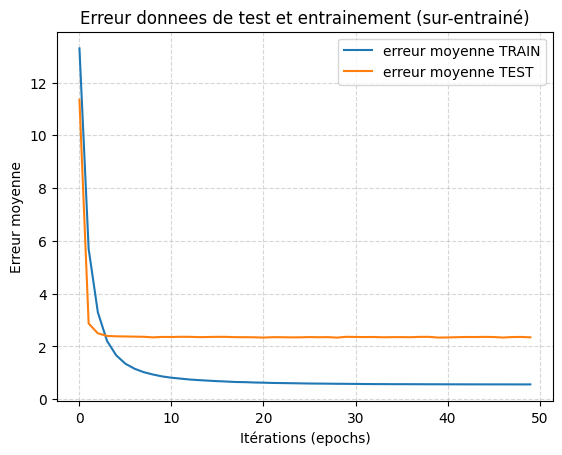

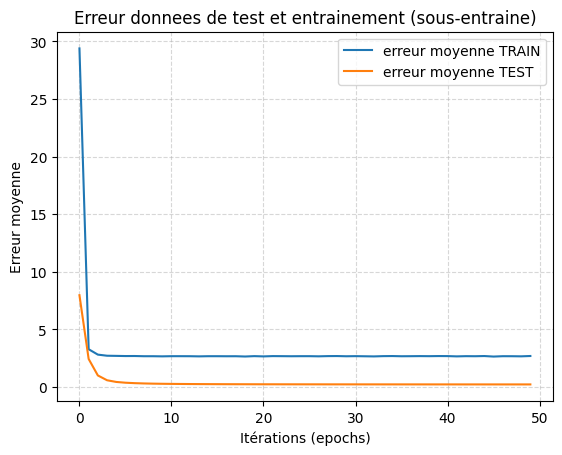

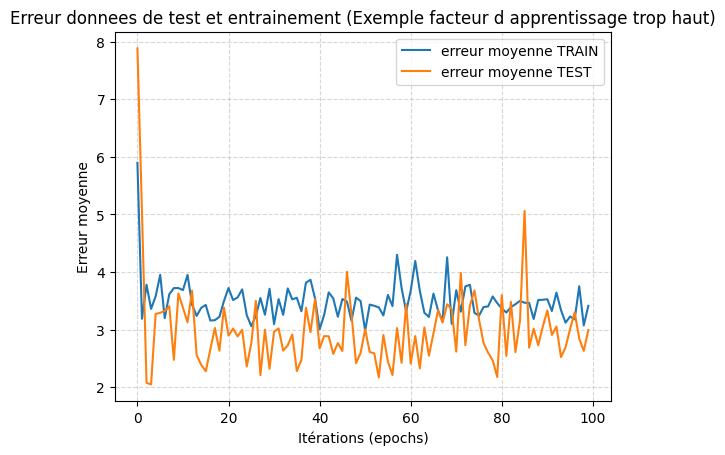

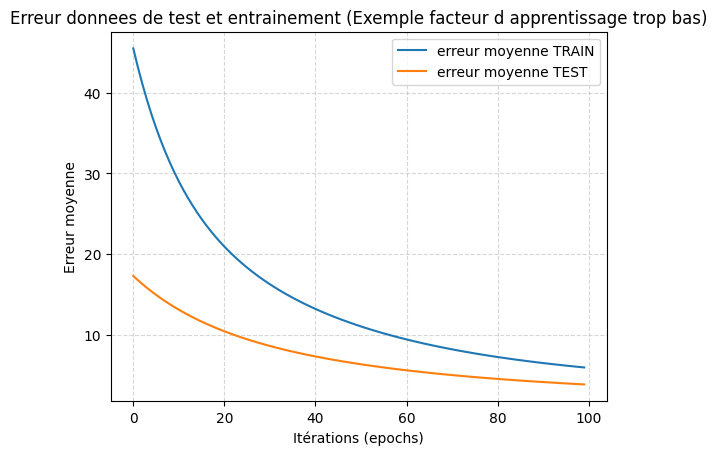

In [42]:
# Exemple sur-entrainé

donnees_entrainement, sorties_entrainement, donnees_test, sorties_test = donnees_entrainement_test(entrees, sorties, 0.8)
matrice_poids, vecteur_biais, tab_erreur_moyenne = widrow_hoff(donnees_entrainement, sorties_entrainement, 0.008, 50)
matrice_poids_test, vecteur_biais_test, tab_erreur_moyenne_test = widrow_hoff(donnees_test, sorties_test, 0.008, 50)

plt.plot(tab_erreur_moyenne, label="erreur moyenne TRAIN")
plt.plot(tab_erreur_moyenne_test, label="erreur moyenne TEST")
plt.xlabel("Itérations (epochs)")
plt.ylabel("Erreur moyenne")
plt.title("Erreur donnees de test et entrainement (sur-entrainé)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


# Exemple sous-entraine 

donnees_entrainement, sorties_entrainement, donnees_test, sorties_test = donnees_entrainement_test(entrees, sorties, 0.1)
matrice_poids, vecteur_biais, tab_erreur_moyenne = widrow_hoff(donnees_entrainement, sorties_entrainement, 0.008, 50)
matrice_poids_test, vecteur_biais_test, tab_erreur_moyenne_test = widrow_hoff(donnees_test, sorties_test, 0.008, 50)

plt.plot(tab_erreur_moyenne, label="erreur moyenne TRAIN")
plt.plot(tab_erreur_moyenne_test, label="erreur moyenne TEST")
plt.xlabel("Itérations (epochs)")
plt.ylabel("Erreur moyenne")
plt.title("Erreur donnees de test et entrainement (sous-entraine)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()



# Exemple facteur d apprentissage trop haut

donnees_entrainement, sorties_entrainement, donnees_test, sorties_test = donnees_entrainement_test(entrees, sorties, 0.4)
matrice_poids, vecteur_biais, tab_erreur_moyenne = widrow_hoff(donnees_entrainement, sorties_entrainement, 0.2, 100)
matrice_poids_test, vecteur_biais_test, tab_erreur_moyenne_test = widrow_hoff(donnees_test, sorties_test, 0.2, 100)

plt.plot(tab_erreur_moyenne, label="erreur moyenne TRAIN")
plt.plot(tab_erreur_moyenne_test, label="erreur moyenne TEST")
plt.xlabel("Itérations (epochs)")
plt.ylabel("Erreur moyenne")
plt.title("Erreur donnees de test et entrainement (Exemple facteur d apprentissage trop haut)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


# Exemple facteur d apprentissage trop bas

donnees_entrainement, sorties_entrainement, donnees_test, sorties_test = donnees_entrainement_test(entrees, sorties, 0.4)
matrice_poids, vecteur_biais, tab_erreur_moyenne = widrow_hoff(donnees_entrainement, sorties_entrainement, 0.0001, 100)
matrice_poids_test, vecteur_biais_test, tab_erreur_moyenne_test = widrow_hoff(donnees_test, sorties_test, 0.0001, 100)

plt.plot(tab_erreur_moyenne, label="erreur moyenne TRAIN")
plt.plot(tab_erreur_moyenne_test, label="erreur moyenne TEST")
plt.xlabel("Itérations (epochs)")
plt.ylabel("Erreur moyenne")
plt.title("Erreur donnees de test et entrainement (Exemple facteur d apprentissage trop bas)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()